`pip install -U msgpack matplotlib pyvisa`

In [3]:
from typing import Literal
from time import sleep
import numpy as np, csv
from matplotlib import pyplot as plt
from experiment import Experiment
from pyvisa import ResourceManager

def read(typ: Literal['HIGH', 'MEAN', 'LOW']):
    # 读取脉冲幅度的测量值
    scope.write('MEASUrement:IMMed:SOUrce CH1')  # 设置测量源为通道 1
    scope.write('MEASUrement:IMMed:TYPe ' + typ)  # 设置测量类型为脉冲幅度
    return float(scope.query('MEASUrement:IMMed:VALUE?'))  # 读取脉冲幅度

def write(ch: int, amp: float):
    console = Experiment(init_gpa=False)
    console.add_flodict({
        f'ocra40_v{ch}': (np.array([10, 1000, 2000]), np.array([0, amp, 0])),
    })
    msg = console.run()
    console.__del__()
    return msg[1]

def sweep(ch: int):
    results = []
    def expt(amp: float):
        write(ch, amp)
        sleep(.2)
        high = read('HIGH')
        low = read('LOW')
        results.append([amp, high, low])
        if np.abs(high - low) > 1.2:  # 1.5V/30A
            return True
        return False
    
    scope.write('TRIGger:A:LEVel 0.08')
    for amp in np.linspace(0.02, 0.36, 18):
        if expt(amp):
            break
    scope.write('TRIGger:A:LEVel -0.08')
    for amp in np.linspace(-0.02, -0.36, 18):
        if expt(amp):
            break
    try:
        with open(f'./data/{ch}.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerows(results)
    except FileNotFoundError:
        print('未保存')
    return np.array(results)

try:
    scope.close()
except NameError:
    pass
rm = ResourceManager()
scope = rm.open_resource(rm.list_resources()[0])
scope.query('*IDN?')

'TEKTRONIX,MDO3024,C062071,CF:91.1CT FV:v1.30\n'

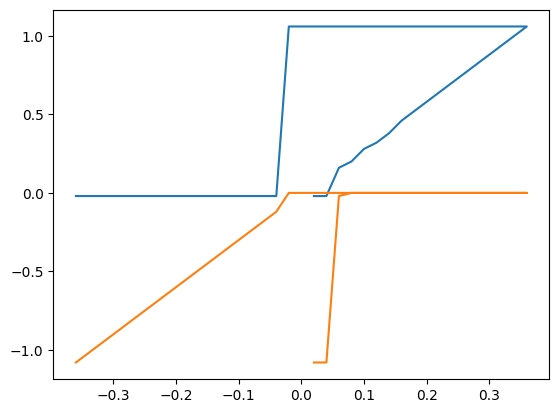

In [161]:
rst = np.array(sweep(0))
plt.plot(rst[:, 0], rst[:, 1])
plt.plot(rst[:, 0], rst[:, 2])

In [ ]:
plt

In [27]:
# scope.query('MEASUrement:IMMed:UNIT?')
scope.write('TRIGger:A:LEVel -0.3')

22

In [31]:
read('LOW')

-0.94

In [3]:
console = Experiment(init_gpa=True)
console.add_flodict({
    f'ocra40_v{ch}': (np.array([0, 100]), np.array([0, 0])) for ch in range(40)
})
console.run()
console.__del__()

d:\gr40c\server_comms.py:86: MarServerWarning: no RX data received
  warnings.warn(k, MarServerWarning)


In [12]:
write(7, 0.1)

{'warnings': ['ocra1 data was lost (overwritten before being sent)',
  'no RX data received']}

In [7]:
console = Experiment(init_gpa=False)
console.add_flodict({
    'ocra40_v4': (np.array([10, 1000, 2000]), np.array([0, -0.3, 0])),
})
msg = console.run()
console.__del__()
msg[1]
sleep(.1)
read('LOW')

-0.0376

In [36]:
scope.query('TRIGger:STATe?')

'READY\n'